In [10]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL.Image
import scipy.misc
from download_net import download_vgg
from sys import stderr

import vgg

try:
    reduce
except NameError:
    from functools import reduce

In [2]:
data_dir = 'data/'
download_vgg(data_dir)

Model already downloaded


In [13]:
CONTENT_WEIGHT = 5e0
CONTENT_WEIGHT_BLEND = 1
STYLE_WEIGHT = 5e2
TV_WEIGHT = 1e2
STYLE_LAYER_WEIGHT_EXP = 1
LEARNING_RATE = 1e1
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-08
STYLE_SCALE = 1.0
ITERATIONS = 1000
VGG_PATH = 'data/imagenet-vgg-verydeep-19.mat'
POOLING = 'max'
DEVICE = '/cpu:0'
# DEVICE= '/gpu:0' # uncomment this line if you wish to use the gpu on your machine


CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

# Style Transfer
This notebook demonstrates the original Style Transfer Algorithm written using TensorFlow. It accompanies the [Machine Learning at Berkeley](http://ml.berkeley.edu/) workshop "Making Art with Deep Learning", originally held October 10, 2017.

Adapted heavily from Anish Athalye's ["Neural Style"](https://github.com/anishathalye/neural-style). Licensed uner the GPL-3.0 license.

Note: On an Intel i7 cpu, 1000 iterations of the algorithm takes roughly 90 minutes for a 512x512 image. On a Titan X GPU, the algortihm takes 2.5 minutes. If you don't have an NVIDIA gpu handy, a better alternative is to use fast-style-transfer, which is also in this repo. 

In [34]:
def load_image(filename):
    '''
    Loads an image. 
    includes special logic for .png files which plt.imread loads to have values between 
    (0,1) and occasionally including 4 channels (4th being for alpha)
    '''
    if '.png' in filename: 
        
        img_obj = plt.imread(filename)*255
    else:
        img_obj = plt.imread(filename)
    img_obj = np.float32(img_obj)
    if len(img_obj.shape) == 3 and img_obj.shape[2] > 3:
        return img_obj[:,:,:3]
    else:
        return img_obj
def show_image(a,save=False,save_fname=None):
    ''' display the image using matplotlib'''
    plt.figure(figsize=(8,6))
    a = np.uint8(np.clip(a, 0, 255))
    plt.imshow(a)
    plt.show()
    if save:
        if save_fname is None:
            raise ValueError('save_fname must be set if save=True')
        plt.imsave(save_fname,a)
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10),dpi=200)

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [25]:
# Copyright (c) 2015-2017 Anish Athalye. Released under GPLv3.

import vgg


def stylize(network, initial, initial_noiseblend, content, styles, preserve_colors, iterations,
        content_weight, content_weight_blend, style_weight, style_layer_weight_exp, style_blend_weights, tv_weight,
        learning_rate, beta1, beta2, epsilon, pooling, device,
        print_iterations=None, checkpoint_iterations=None):
    """
    Stylize images.

    This function yields tuples (iteration, image); `iteration` is None
    if this is the final image (the last iteration).  Other tuples are yielded
    every `checkpoint_iterations` iterations.

    :rtype: iterator[tuple[int|None,image]]
    """
    shape = (1,) + content.shape
    style_shapes = [(1,) + style.shape for style in styles]
    content_features = {}
    style_features = [{} for _ in styles]

    vgg_weights, vgg_mean_pixel = vgg.load_net(network)

    layer_weight = 1.0
    style_layers_weights = {}
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] = layer_weight
        layer_weight *= style_layer_weight_exp

    # normalize style layer weights
    layer_weights_sum = 0
    for style_layer in STYLE_LAYERS:
        layer_weights_sum += style_layers_weights[style_layer]
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] /= layer_weights_sum

    # compute content features in feedforward mode
    g = tf.Graph()
    with g.as_default(), g.device(device), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)
        net = vgg.net_preloaded(vgg_weights, image, pooling)
        content_pre = np.array([vgg.preprocess(content, vgg_mean_pixel)])
        for layer in CONTENT_LAYERS:
            content_features[layer] = net[layer].eval(feed_dict={image: content_pre})

    # compute style features in feedforward mode
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), g.device(device), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net = vgg.net_preloaded(vgg_weights, image, pooling)
            style_pre = np.array([vgg.preprocess(styles[i], vgg_mean_pixel)])
            for layer in STYLE_LAYERS:
                features = net[layer].eval(feed_dict={image: style_pre})
                features = np.reshape(features, (-1, features.shape[3]))
                gram = np.matmul(features.T, features) / features.size
                style_features[i][layer] = gram

    initial_content_noise_coeff = 1.0 - initial_noiseblend

    # make stylized image using backpropogation
    with tf.Graph().as_default():
        g.device(device)
        if initial is None:
            noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
            initial = tf.random_normal(shape) * 0.256
        else:
            initial = np.array([vgg.preprocess(initial, vgg_mean_pixel)])
            initial = initial.astype('float32')
            noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
            initial = (initial) * initial_content_noise_coeff + (tf.random_normal(shape) * 0.256) * \
                (1.0 - initial_content_noise_coeff)
        image = tf.Variable(initial)
        net = vgg.net_preloaded(vgg_weights, image, pooling)

        # content loss
        content_layers_weights = {}
        content_layers_weights['relu4_2'] = content_weight_blend
        content_layers_weights['relu5_2'] = 1.0 - content_weight_blend

        content_loss = 0
        content_losses = []
        for content_layer in CONTENT_LAYERS:
            content_losses.append(content_layers_weights[content_layer] * content_weight * (2 * tf.nn.l2_loss(
                    net[content_layer] - content_features[content_layer]) /
                    content_features[content_layer].size))
        content_loss += reduce(tf.add, content_losses)

        # style loss
        style_loss = 0
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:
                layer = net[style_layer]
                _, height, width, number = map(lambda i: i.value, layer.get_shape())
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))
                gram = tf.matmul(tf.transpose(feats), feats) / size
                style_gram = style_features[i][style_layer]
                style_losses.append(style_layers_weights[style_layer] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)

        # total variation denoising
        tv_y_size = _tensor_size(image[:,1:,:,:])
        tv_x_size = _tensor_size(image[:,:,1:,:])
        tv_loss = tv_weight * 2 * (
                (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                    tv_y_size) +
                (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                    tv_x_size))
        # overall loss
        loss = content_loss + style_loss + tv_loss

        # optimizer setup
        train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

        def print_progress():
            stderr.write('  content loss: %g\n' % content_loss.eval())
            stderr.write('    style loss: %g\n' % style_loss.eval())
            stderr.write('       tv loss: %g\n' % tv_loss.eval())
            stderr.write('    total loss: %g\n' % loss.eval())

        # optimization
        best_loss = float('inf')
        best = None
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            stderr.write('Optimization started...\n')
            if (print_iterations and print_iterations != 0):
                print_progress()
            for i in range(iterations):
                
                train_step.run()

                last_step = (i == iterations - 1)
                if last_step or (print_iterations and i % print_iterations == 0):
                    print_progress()

                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
#                     stderr.write('Iteration %4d/%4d\n' % (i + 1, iterations))
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()

                    img_out = vgg.unprocess(best.reshape(shape[1:]), vgg_mean_pixel)

                    if preserve_colors and preserve_colors == True:
                        original_image = np.clip(content, 0, 255)
                        styled_image = np.clip(img_out, 0, 255)

                        # Luminosity transfer steps:
                        # 1. Convert stylized RGB->grayscale accoriding to Rec.601 luma (0.299, 0.587, 0.114)
                        # 2. Convert stylized grayscale into YUV (YCbCr)
                        # 3. Convert original image into YUV (YCbCr)
                        # 4. Recombine (stylizedYUV.Y, originalYUV.U, originalYUV.V)
                        # 5. Convert recombined image from YUV back to RGB

                        # 1
                        styled_grayscale = rgb2gray(styled_image)
                        styled_grayscale_rgb = gray2rgb(styled_grayscale)

                        # 2
                        styled_grayscale_yuv = np.array(Image.fromarray(styled_grayscale_rgb.astype(np.uint8)).convert('YCbCr'))

                        # 3
                        original_yuv = np.array(Image.fromarray(original_image.astype(np.uint8)).convert('YCbCr'))

                        # 4
                        w, h, _ = original_image.shape
                        combined_yuv = np.empty((w, h, 3), dtype=np.uint8)
                        combined_yuv[..., 0] = styled_grayscale_yuv[..., 0]
                        combined_yuv[..., 1] = original_yuv[..., 1]
                        combined_yuv[..., 2] = original_yuv[..., 2]

                        # 5
                        img_out = np.array(Image.fromarray(combined_yuv, 'YCbCr').convert('RGB'))


                    yield (
                        (None if last_step else i),
                        img_out
                    )


def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gray2rgb(gray):
    w, h = gray.shape
    rgb = np.empty((w, h, 3), dtype=np.float32)
    rgb[:, :, 2] = rgb[:, :, 1] = rgb[:, :, 0] = gray
    return rgb

In [31]:
def style_transfer(content_image, style_images, 
                width=None, 
                style_blend_weights=None, 
                content_weight_blend=CONTENT_WEIGHT_BLEND,
                style_scales=None,
                content_weight=CONTENT_WEIGHT,
                style_weight=STYLE_WEIGHT,
                initial_img=None, 
                initial_noiseblend=None,
                network_path=VGG_PATH,
                preserve_color=False,                   
                iterations=ITERATIONS,
                beta1=BETA1,
                beta2=BETA2,
                tv_weight=TV_WEIGHT,
                learning_rate=LEARNING_RATE,
                epsilon=EPSILON,
                pooling=POOLING,
                style_layer_weight_exp=STYLE_LAYER_WEIGHT_EXP,
                print_iterations=0,
                checkpoint_iterations=100,
                save_checkpoint=False,
                checkpoint_path=None,
                last_output_file=None,
                preserve_colors=False,
                device=DEVICE,
                   
                
                
                  ):
    '''
    Runs the style transfer algorithm
    '''
    if type(style_images) is not list:
        raise ValueError('style images must be a list. ' +
                         'If you have one style, wrap it in brackets []')

    if width is not None:
        new_shape = (int(math.floor(float(content_image.shape[0]) /
                content_image.shape[1] * width)), width)
        content_image = scipy.misc.imresize(content_image, new_shape)
    target_shape = content_image.shape
    
    for i in range(len(style_images)):
        style_scale = STYLE_SCALE
        if style_scales is not None:
            style_scale = style_scales[i]
        style_images[i] = scipy.misc.imresize(style_images[i], style_scale *
                target_shape[1] / style_images[i].shape[1])
                
    if style_blend_weights is None:
        # default is equal weights
        style_blend_weights = [1.0/len(style_images) for _ in style_images]
    else:
        total_blend_weight = sum(style_blend_weights)
        style_blend_weights = [weight/total_blend_weight
                               for weight in style_blend_weights]
                               
    if initial_img is not None:
        initial_img = scipy.misc.imresize(imread(initial_img), content_image.shape[:2])
        # initial_img guess is specified, but not noiseblend - no noise should be blended
        if initial_noiseblend is None:
            initial_noiseblend = 0.0
    else:
        # Neither inital, nor noiseblend is provided, falling back to random generated initial_img guess
        if initial_noiseblend is None:
            initial_noiseblend = 1.0
        if initial_noiseblend < 1.0:
            initial_img = content_image
    if checkpoint_path and "%s" not in checkpoint_path:
        raise ValueError("To save intermediate images, the checkpoint output "
                     "parameter must contain `%s` (e.g. `foo%s.jpg`)")
    
    for iteration, image in stylize(
        network=network_path,
        initial=initial_img,
        initial_noiseblend=initial_noiseblend,
        content=content_image,
        styles=style_images,
        preserve_colors=preserve_colors,
        iterations=iterations,
        content_weight=content_weight,
        content_weight_blend=content_weight_blend,
        style_weight=style_weight,
        style_layer_weight_exp=style_layer_weight_exp,
        style_blend_weights=style_blend_weights,
        tv_weight=tv_weight,
        learning_rate=learning_rate,
        beta1=beta1,
        beta2=beta2,
        epsilon=epsilon,
        pooling=pooling,
        print_iterations=print_iterations,
        checkpoint_iterations=checkpoint_iterations,
        device=device,
    ):
        output_file = None
        combined_rgb = image
        if iteration is not None:
            if checkpoint_path:
                output_file = checkpoint_path % iteration
            print("Iteration {}".format(iteration))
        else:
            output_file = last_output_file
            print("Output after {} iterations".format(iterations))

        if output_file:
            show_image(combined_rgb,save=True,save_fname=output_file)
        else:
            show_image(combined_rgb)
    return combined_rgb
# style_transfer(content_img, [style_img])

content image


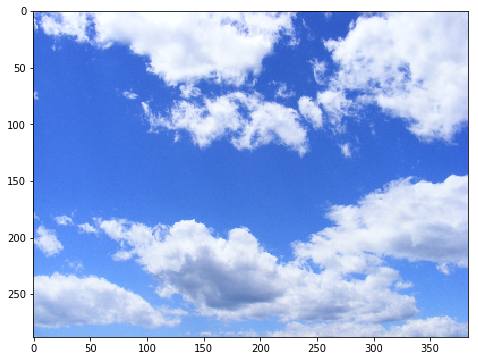

style image


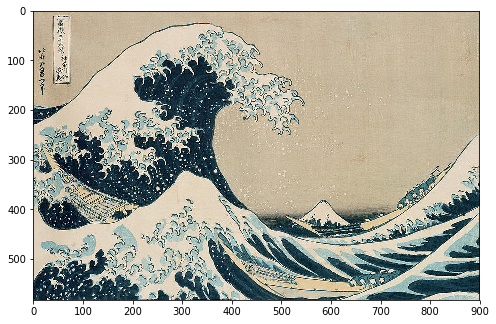

In [40]:
content_img = load_image('images/sky.jpg')
style_img = load_image('images/wave.jpg')
print('content image')
show_image(content_img)
print('style image')
show_image(style_img)


Optimization started...
  content loss: 1.30165e+06
    style loss: 301008
       tv loss: 98001.7
    total loss: 1.70066e+06


Output after 1000 iterations


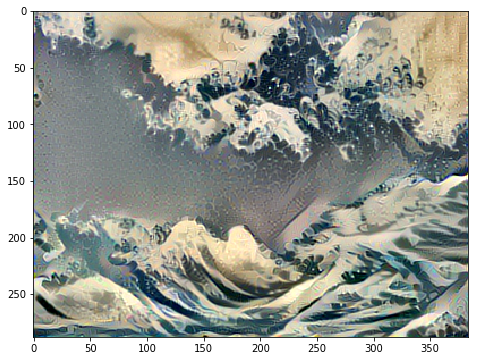

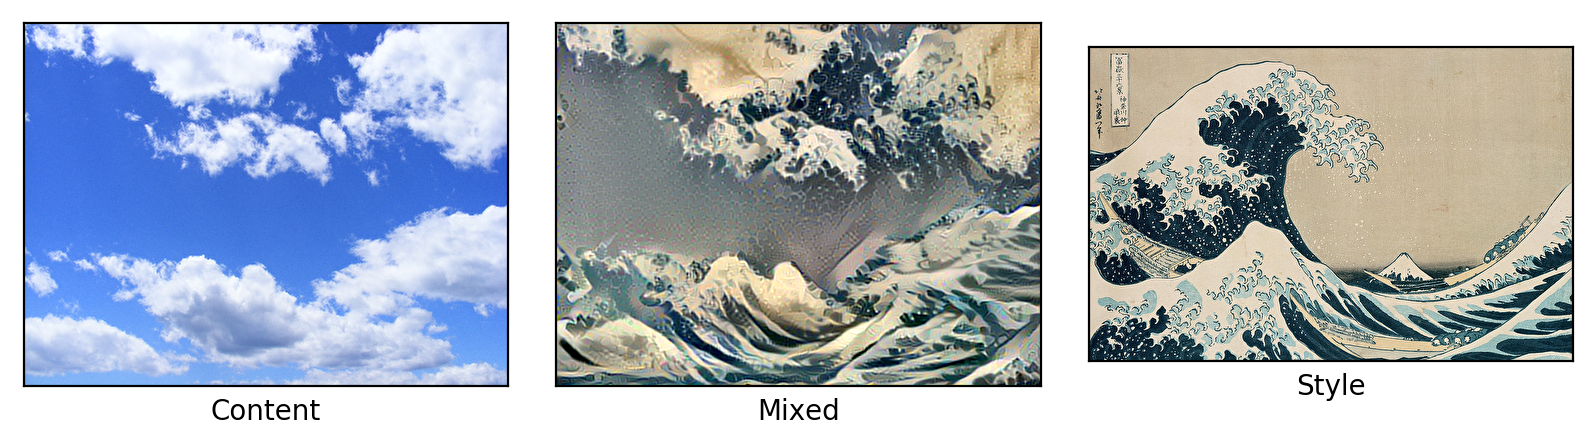

In [41]:
out_img = style_transfer(content_img, [style_img], checkpoint_iterations=0)
plot_images(content_img, style_img, out_img)

content image


style image


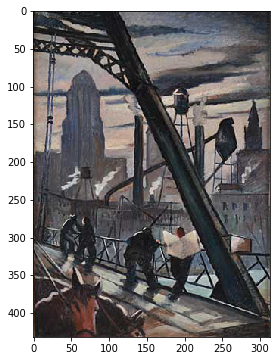

In [38]:
content_img = load_image('images/city-content.jpg')
style_img = load_image('images/city-style.jpg')
print('content image')
show_image(content_img)
print('style image')
show_image(style_img)

Optimization started...
  content loss: 1.96866e+06
    style loss: 232565
       tv loss: 23079.2
    total loss: 2.2243e+06


Output after 1000 iterations


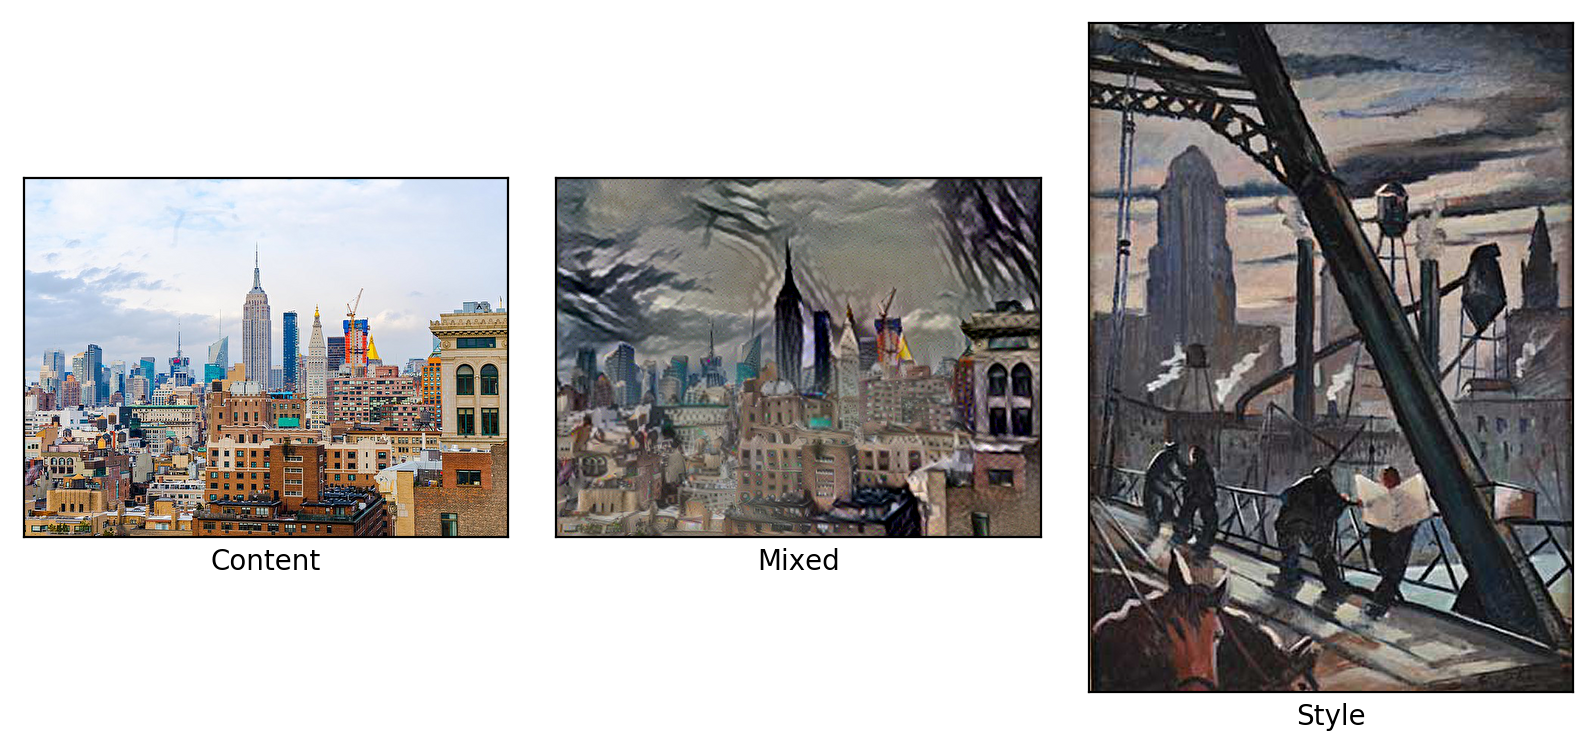

In [39]:

out_img = style_transfer(content_img, [style_img], checkpoint_iterations=0)
plot_images(content_img, style_img, out_img)